In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset

In [2]:
os.chdir("/g/data/jr19/rh2942/text-empathy/")
from evaluation import pearsonr
from utils.plot import plot

In [3]:
def get_device(device_id=0):
    return torch.device("cuda", device_id) if torch.cuda.is_available() else torch.device("cpu")

def set_all_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [4]:
tasks = ['empathy', 'distress']

checkpoint = "microsoft/deberta-v3-base"

train_file = "./data/PREPROCESSED-essay-train.csv"
dev_file = "./data/PREPROCESSED-essay-dev.csv"
train_dev_file = "./data/PREPROCESSED-essay-train-dev.csv"
test_file = "./data/PREPROCESSED-test.csv"

In [5]:
features = ['demographic_essay', 'article']

In [6]:
tokeniser = AutoTokenizer.from_pretrained(checkpoint, use_fast=False) # fast tokeniser showed warning that it may return incorrect tokens

# data collator due to variable max token length per batch size
data_collator = DataCollatorWithPadding(tokenizer = tokeniser)

def load_tokenised_data(filename, tasks, feature_to_tokenise, train, batch_size, shuffle):
    #padding="longest" can be deferred to do dynamic padding
    def tokenise_fn(sentence):
        return tokeniser(sentence[feature_to_tokenise[0]], sentence[feature_to_tokenise[1]], truncation=True, max_length=512)
   
    input_data = pd.read_csv(filename, header=0, index_col=0)
    
    if train:
        chosen_data = input_data[feature_to_tokenise + tasks]
    else:
        chosen_data = input_data[feature_to_tokenise]  #test data shouldn't have output label

    hugging_dataset = Dataset.from_pandas(chosen_data, preserve_index=False)

    tokenised_hugging_dataset = hugging_dataset.map(tokenise_fn, batched=True, remove_columns = feature_to_tokenise)
    
    tokenised_hugging_dataset = tokenised_hugging_dataset.with_format("torch")
    
    torchloader = torch.utils.data.DataLoader(
        tokenised_hugging_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=data_collator
    )

    return torchloader

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def get_data(tasks, features, batch_size):
    """
    feature: list of features to tokenise
    """
    
    trainloader = load_tokenised_data(
        filename=train_file, tasks=tasks, feature_to_tokenise=features, train=True, batch_size=batch_size, shuffle=True
    )

        # devloader in train mode to pass labels
    devloader = load_tokenised_data(
        filename=dev_file, tasks=tasks, feature_to_tokenise=features, train=True, batch_size=batch_size, shuffle=False
    )

    return trainloader, devloader

def get_test_data(tasks, features, batch_size):
    """
    feature: list of features to tokenise
    """
    
    testloader = load_tokenised_data(
        filename=test_file, tasks=tasks, feature_to_tokenise=features, train=False, batch_size=batch_size, shuffle=False
    )

    return testloader

In [8]:
class RecurrentGuidedTransformer(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1, task=tasks[0]):
        super(RecurrentGuidedTransformer, self).__init__()

        self.task = task
        self.transformer_last_hidden_size = 768
        
        self.transformer = AutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True,
                num_labels=self.transformer_last_hidden_size
            )
        )

        self.transformer_2 = AutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True,
                num_labels=self.transformer_last_hidden_size
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0.25)

        # 1st stream
        self.fc1_1 = nn.Linear(self.transformer_last_hidden_size, 256)
        
        self.fc1_2 = nn.Linear(256, 1) # predicting distress

        # 2nd stream
        self.fc2_1 = nn.Linear(769, 256) # input: last hidden state + distress

        self.fc_final = nn.Linear(256, 1) # regression problem
        

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer.deberta.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer.deberta.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        empathy=None,
        distress=None
    ):
        
        outputs = self.transformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        # print(outputs.keys())
        # will return ['logits', 'hidden_states', 'attentions']

        x = self.dropout(outputs.logits) # output.logits aka pooled output from [CLS] token beacuse of AutoModelForSequenceClassification
        x = F.tanh(self.fc1_1(x))
        x = self.dropout(x)
        x = self.fc1_2(x) # distress output

        # starting 2nd stream
        outputs = self.transformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )

        x_2 = self.dropout(outputs.logits) # output.logits aka pooled output from [CLS] token beacuse of AutoModelForSequenceClassification
        x_2 = torch.cat((x_2, x), dim=1)

        x_2 = F.tanh(self.fc2_1(x_2))
        x_2 = self.dropout(x_2)
        x_2 = self.fc_final(x_2) # distress output     

        if self.task == tasks[0]: # empathy
            loss_distress = None
            if distress is not None:
                loss_distress = F.mse_loss(x.view(-1), distress.view(-1))
    
            loss_empathy = None
            if empathy is not None:
                loss_empathy = F.mse_loss(x_2.view(-1), empathy.view(-1))
            
            return (
                SequenceClassifierOutput(
                    loss=loss_distress,
                    logits=x
                ),
                SequenceClassifierOutput(
                    loss=loss_empathy,
                    logits=x_2
                )
            )

        elif self.task == tasks[1]: # distress
            loss_empathy = None
            if empathy is not None:
                loss_empathy = F.mse_loss(x.view(-1), empathy.view(-1))
                
            loss_distress = None
            
            if distress is not None:
                loss_distress = F.mse_loss(x_2.view(-1), distress.view(-1))
    
            
            return (
                SequenceClassifierOutput(
                    loss=loss_empathy,
                    logits=x_2
                ),
                SequenceClassifierOutput(
                    loss=loss_distress,
                    logits=x
                )
            )

In [9]:
def train(tasks=tasks, final_task=tasks[0], lr=1e-5, batch_size=8, n_epochs=3, seed=1, save=False):
    set_all_seeds(seed)
    
    model = RecurrentGuidedTransformer(n_freeze=0, task=final_task)
    device = get_device(0)
    model.to(device)

    # print(model)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
              
    trainloader, devloader = get_data(tasks=tasks, features=features, batch_size=batch_size)

    training_steps = n_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )

    train_loss = []
    val_loss = []
    corr = []
    for epoch in range(0, n_epochs):
        total_loss = 0.0
        model.train()
        for batch in trainloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            opt.zero_grad()
            (outputs_1, outputs_2) = model(**batch)
            loss_1 = outputs_1.loss
            loss_2 = outputs_2.loss
            loss_1.backward(retain_graph=True)
            loss_2.backward()
            
            opt.step()
            lr_scheduler.step()

            total_loss += loss_2.item()

        train_loss.append(total_loss / len(trainloader)) # len(trainloader) == num_batches

        total_loss = 0.0
        model.eval()
        y_pred = []
        y_true = []
        for batch in devloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                (_, outputs_2) = model(**batch)

            batch_pred = [item for sublist in outputs_2.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred)
            y_true.extend((batch[final_task].tolist()))
            total_loss += outputs_2.loss.item()
        
        val_loss.append(total_loss / len(devloader))

        # print(y_pred)
        corr.append(pearsonr(y_true, y_pred))
        print("pearson_r:", corr[-1]) # -1 index refer to the last (current) correlation
        
        if save and epoch > 0 and (corr[-1] > max(corr[:-1])): #after first epoch, if the last score is greater than max of all but last score
            filename = "model" + final_task + ".pth"
            torch.save(model.state_dict(), filename)
            print("Saved the model as " + filename + " in epoch " + str(epoch+1))
            
    # train-test finished
    plot(
        x=list(range(1, n_epochs+1)),
        y=train_loss,
        y2=val_loss,
        xlabel='Epoch',
        ylabel='Loss',
        legend=['Training loss', 'Validation loss'],
        save=False,
        filename=None
    )

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.121
pearson_r: 0.181
pearson_r: 0.449
pearson_r: 0.646
pearson_r: 0.698
pearson_r: 0.699
pearson_r: 0.739
pearson_r: 0.73
pearson_r: 0.74
pearson_r: 0.749
pearson_r: 0.727
pearson_r: 0.719
pearson_r: 0.747
pearson_r: 0.757
pearson_r: 0.72
pearson_r: 0.725
pearson_r: 0.75
pearson_r: 0.743
pearson_r: 0.737
pearson_r: 0.737


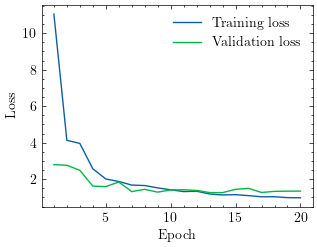

In [10]:
train(tasks=tasks, final_task=tasks[0], lr=1e-5, batch_size=8, n_epochs=20, seed=1, save=False)

In [11]:
torch.cuda.empty_cache()

In [12]:
train(tasks=tasks, final_task=tasks[1], lr=1e-5, batch_size=8, n_epochs=20, seed=1, save=False)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.072
pearson_r: 0.237
pearson_r: 0.347
pearson_r: 0.55
pearson_r: 0.673
pearson_r: 0.675
pearson_r: 0.63
pearson_r: 0.675
pearson_r: 0.695


KeyboardInterrupt: 

# Test

In [13]:
torch.cuda.empty_cache()

In [14]:
def test(tasks=tasks, final_task=tasks[0], batch_size=8, seed=1):

    model = RecurrentGuidedTransformer(n_freeze=0, task=final_task)
    device = get_device()
    model.to(device)

    # load the trained parameters
    filename = "model" + final_task + ".pth"
    model.load_state_dict(torch.load(filename))
    print(f"Loaded model: {filename}")
    
    testloader = get_test_data(tasks=tasks, features=features, batch_size=batch_size)

    model.eval()
    y_pred = []
    for batch in testloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            (_, outputs_2) = model(**batch)

        batch_pred = [item for sublist in outputs_2.logits.tolist() for item in sublist]  #convert 2D list to 1D
        y_pred.extend(batch_pred)

    return y_pred

In [15]:
y_pred_emp = test(tasks=tasks, final_task=tasks[0], batch_size=8, seed=1)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Loaded model: modelempathy.pth


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [16]:
torch.cuda.empty_cache()

In [17]:
y_pred_dis = test(tasks=tasks, final_task=tasks[1], batch_size=8, seed=1)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Loaded model: modeldistress.pth


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [18]:
# for submission to CodaLab
y_pred = pd.DataFrame({
    tasks[0]: y_pred_emp,
    tasks[1]: y_pred_dis
})
y_pred.to_csv("./tmp/predictions_EMP.tsv", sep='\t', header=False, index=False)